In [1]:
import pandas as pd
import numpy as np
import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import wordcloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
tweet  = pd.read_csv(r"../twitter_data.csv")

In [3]:
tweet

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
tweet.target.unique()

array([1, 0], dtype=int64)

> Here we can see target column have two unique value 1 means it is a disaster tweet and 0 means it is non-disaster tweets

In [5]:
tweet.shape

(7613, 5)

In [6]:
tweet.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
tweet.tail(5)

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


> Here we are observing that the shape of the data is 7613 rows and 5 columns but we can see our id is more than 10000 it is because our id is not in sequence

In [9]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


> there is no null value in the text and target columns 

## Exploratory Data Analysis

### Target Class distribution

In [10]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 80

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_37296\93431867.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target',data=tweet,palette=palette)


Text(0.5, 1.0, 'Disaster or not Disaster tweets')

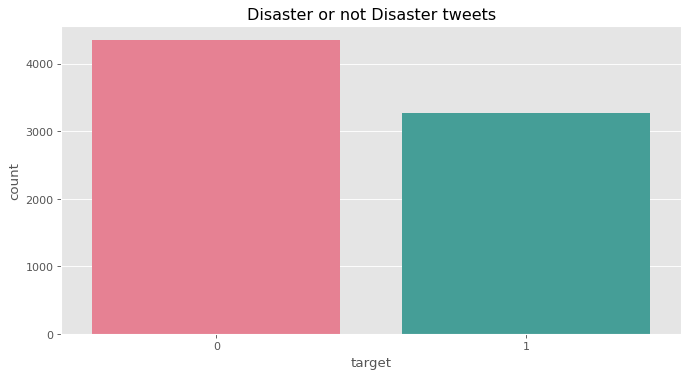

In [11]:
palette = sns.color_palette("husl", 2)
sns.countplot(x='target',data=tweet,palette=palette)
plt.title('Disaster or not Disaster tweets')

In [12]:
tweet['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: ylabel='count'>

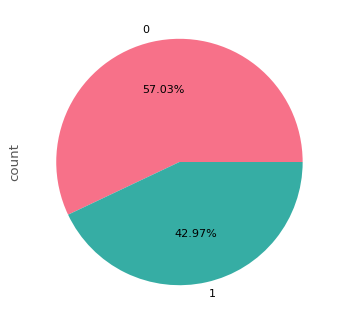

In [13]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%',colors=palette)

### Numbers of characters Distributions in tweets

In [14]:
import utils

In [15]:

tweet = utils.get_basic_features(tweet)
tweet


,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,73,11,6.636364,2,0,0,2,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,106,20,5.300000,9,0,2,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,58,8,7.250000,1,0,0,7,2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,119,19,6.263158,6,0,0,2,0


In [16]:
#import sys
#sys.path.append(r'D:\Project_7_Disaster_tweets_classification\notebook\utils.py')  # Replace '/path/to/utils.py' with the actual path


<Axes: xlabel='char_counts', ylabel='Count'>

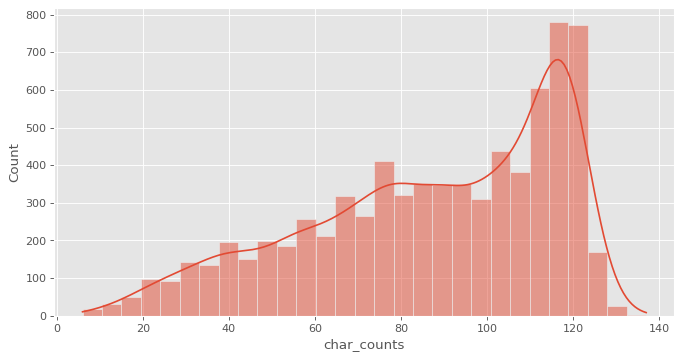

In [17]:
sns.histplot(tweet['char_counts'],kde=True)

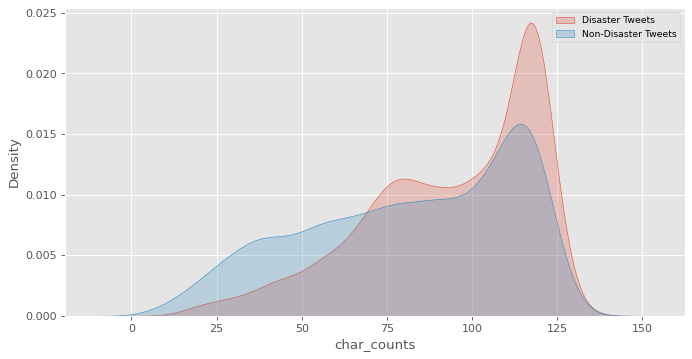

In [18]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'],fill=True,label='Disaster Tweets')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'],fill=True,label='Non-Disaster Tweets')
plt.legend(fontsize='small')
plt.show()

> Here we can see when there is a disater tweets character counts increases

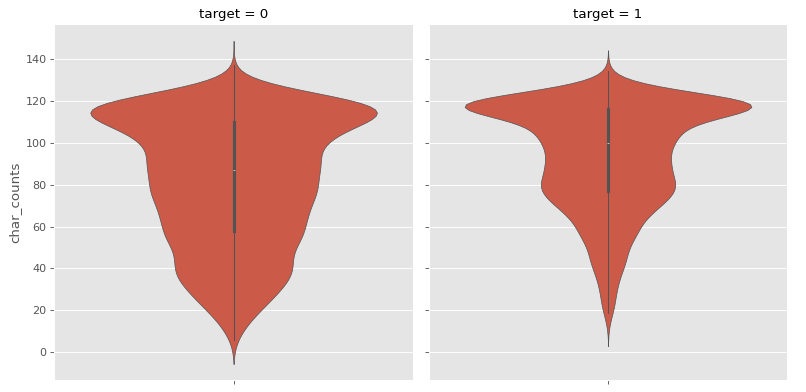

In [19]:
sns.catplot(y='char_counts',data=tweet,kind='violin',col='target')

### Number of words,average words length and stop words distribution in tweets

In [20]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

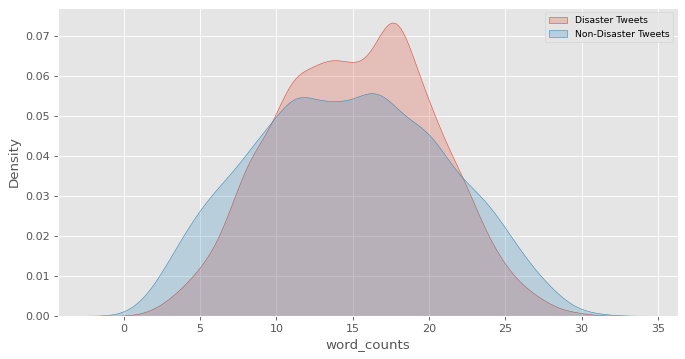

In [21]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'],fill=True,label='Disaster Tweets')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'],fill=True,label='Non-Disaster Tweets')
plt.legend(fontsize='small')
plt.show()

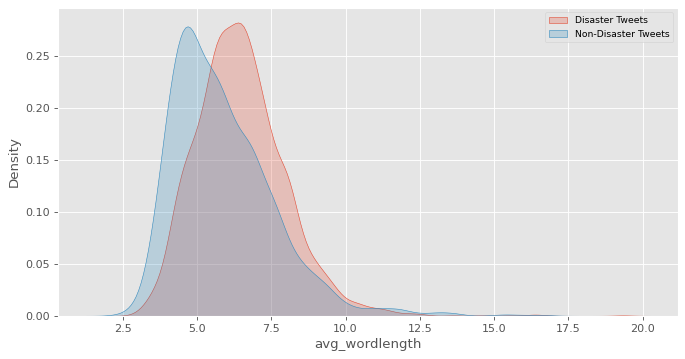

In [22]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'],fill=True,label='Disaster Tweets')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'],fill=True,label='Non-Disaster Tweets')
plt.legend(fontsize='small')
plt.show()

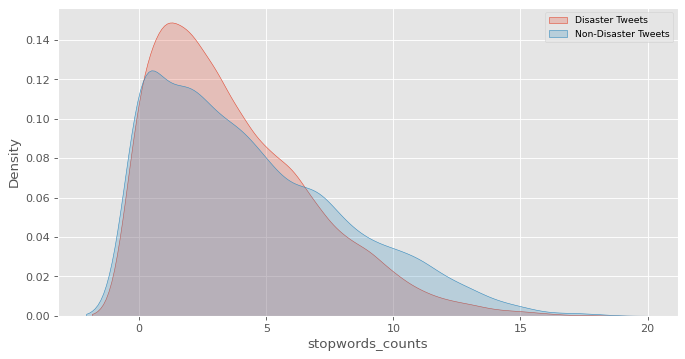

In [23]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'],fill=True,label='Disaster Tweets')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'],fill=True,label='Non-Disaster Tweets')
plt.legend(fontsize='small')
plt.show()

### most and least common words 

In [24]:
word_freq = utils.get_word_frequency(tweet, 'text')
word_freq

the                        2575
a                          1845
to                         1805
in                         1757
of                         1722
                           ... 
https://t.co/NlJVP3Vfyz       1
(Ft.                          1
Dix                           1
bandolier                     1
http://t.co/YmY4rSkQ3d        1
Name: count, Length: 31924, dtype: int64

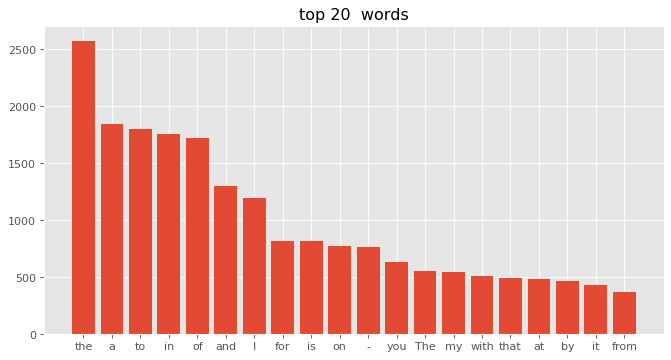

In [25]:
top_20_words = word_freq.head(20).sort_values(ascending=False)
plt.title("top 20  words")
plt.bar(top_20_words.index,top_20_words)
plt.show()

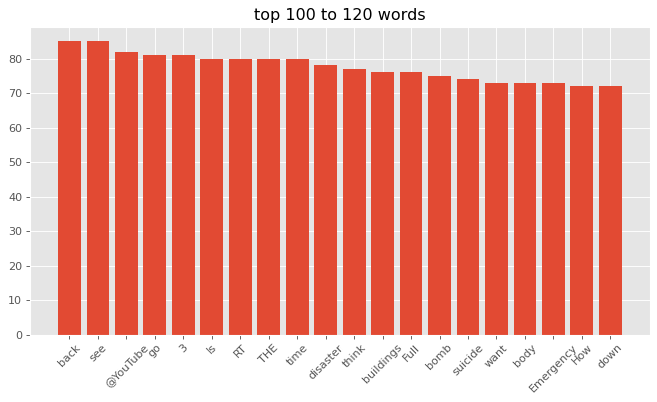

In [26]:
top_100_to_120_words = word_freq[100:120]
plt.bar(top_100_to_120_words.index,top_100_to_120_words)
plt.title("top 100 to 120 words")
plt.xticks(rotation=45)
plt.show()

In [27]:
least20 = word_freq[-20:]
least20

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
Name: count, dtype: int64

In [28]:
bigram = utils.get_ngram(tweet,'text',ngram_range=2)
"top 10 words",bigram[:10],"last 10 words",bigram[-10:]

('top 10 words',
 [('ûówe work', 68495),
  ('ûótech business', 68494),
  ('ûónegligence and', 68493),
  ('ûókody vine', 68492),
  ('ûóher upper', 68491),
  ('ûó wallybaiter', 68490),
  ('ûó the', 68489),
  ('ûó stories', 68488),
  ('ûó rt', 68487),
  ('ûó richmond', 68486)],
 'last 10 words',
 [('00 pm', 9),
  ('00 in', 8),
  ('00 http', 7),
  ('00 hiroshima', 6),
  ('00 bestseller', 5),
  ('00 at', 4),
  ('00 am', 3),
  ('00 52', 2),
  ('00 25', 1),
  ('00 11', 0)])

# Data cleaning

In [29]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = utils.cont_exp(x)
    x = utils.remove_emails(x)
    x = utils.remove_urls(x)
    x = utils.remove_html_tags(x)
    x = utils.remove_rt(x)
    x = utils.remove_accented_chars(x)
    x = utils.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [30]:
# example 
# x = 'llLooooovvveeee #python'
# x = re.sub("(.)\\1{2,}", "\\1", x)
# print(x)
# ---
# love python

In [31]:
tweet.head()['text']

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [32]:
tweet['text'] =tweet['text'].apply(lambda x: get_clean(x))

d:\Project_7_Disaster_tweets_classification\notebook\utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [33]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

### here we can see our text file is cleaned for example:
> Our Deeds are the Reason of this #earthquake M...

> our deeds are the reason of this earthquake ma...

> here we can see # is removed and all the letters are in lower case



In [34]:
utils.get_ngram(tweet,'text',ngram_range=2)



[('zxathetis are', 60257),
 ('zurich for', 60256),
 ('zumiez is', 60255),
 ('zss vs', 60254),
 ('zourryart forgot', 60253),
 ('zouma just', 60252),
 ('zouma has', 60251),
 ('zotar50 skeleton', 60250),
 ('zoom in', 60249),
 ('zonewolf123 liked', 60248),
 ('zonesthank god', 60247),
 ('zones donuat', 60246),
 ('zone with', 60245),
 ('zone what', 60244),
 ('zone war', 60243),
 ('zone they', 60242),
 ('zone protectdenaliwolves', 60241),
 ('zone outside', 60240),
 ('zone of', 60239),
 ('zone my', 60238),
 ('zone littlewomenla', 60237),
 ('zone laugh', 60236),
 ('zone johnny', 60235),
 ('zone in', 60234),
 ('zone during', 60233),
 ('zone common', 60232),
 ('zone coming', 60231),
 ('zone but', 60230),
 ('zone and', 60229),
 ('zone amirite', 60228),
 ('zombies take', 60227),
 ('zombie fun', 60226),
 ('zombie feel', 60225),
 ('zombie apocalypse', 60224),
 ('zomatoaus lovefood', 60223),
 ('zojadelin you', 60222),
 ('zodiac girl', 60221),
 ('zippoline as', 60220),
 ('zippers bags', 60219),
 ('zipp

In [35]:
tweet.to_csv("clean_tweet.csv")

## Disaster words visualization using word cloud

In [36]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0


In [37]:
# tweets talking about the disasters
real = utils.get_word_frequency(tweet[tweet['target']==1],'text')
real

the             1360
in              1161
of               928
a                923
to               757
                ... 
newly              1
nigeltanner1       1
epilepsy           1
superhero          1
flip               1
Name: count, Length: 9550, dtype: int64

In [38]:
real = ' '.join(real.index)
real

'the in of a to and is on for i at by from it that with not after this fire are was as you have my news over up more via an were disaster be people california suicide has police no who but when been killed like do will just than so hiroshima fires out crash storm families we train about into now emergency your buildings bomb 2 all there mh370 what two nuclear am they video wildfire attack get accident new one bombing burning minister how prime northern legionnaires dead bomber me homes some if war car still atomic fatal he obama years off collapse us may retweet debris watch city forest first japan malaysia mass or latest severe man near water today had earthquake confirmed before those found oil would floods spill down army world warning 70 under evacuation wreckage derailment could injured home outbreak being thunderstorm saudi migrants weather 40 old our s say u flood investigators missing can during flooding bridge time their suspect state death her 3 back mosque kills wounded isla

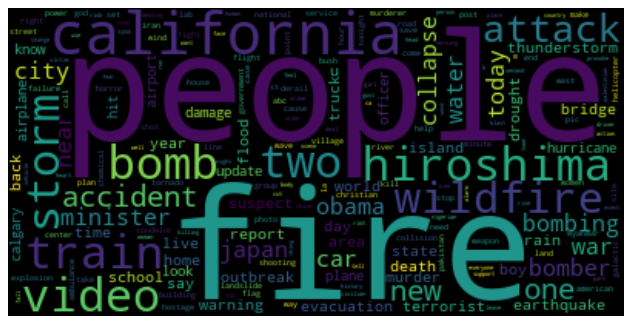

In [39]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt


wordcloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()


In [40]:
# tweets talking about the non-disasters
fake = utils.get_word_frequency(tweet[tweet['target']==0],'text')
fake = ' '.join(fake.index)
fake

'the i a to and of is in you my it for not on that with this have be am are do out me your like so by at just was will but up all he if from new as get they has or we no when now about what would an how one can there body people via been her video into his more loud us back love know time 2 why got off full emergency after them who see day youtube cannot going did still 3 some fire good let go think laughing had she want man our should retweet ass world over life then their first youre way work too burning last need really only than make news god because best here being much even many content take help could were him wreck right say great black feel today hot its fucking never every look down im 5 please cross fear read before ever bags night fuck does top without these bag oh come reddit year any getting another shit everyone liked head screaming bloody ruin may always smoke wrecked death panic school 1 well harm most crash 4 coming bad home disaster face where watch explode uo check 

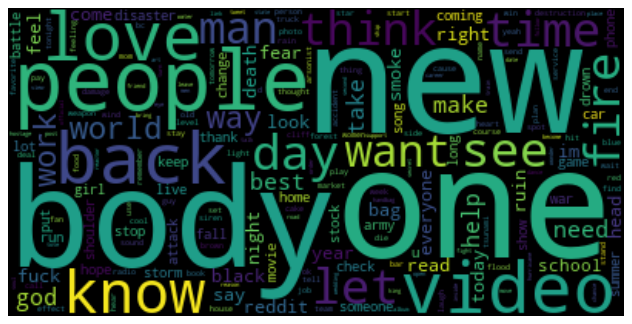

In [41]:
wordcloud = WordCloud(max_font_size=100).generate(fake)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.show()

## classification with TFIDF and SVM

In [42]:
text = tweet['text']
y=tweet['target']

In [43]:
tfidf = TfidfVectorizer()

In [44]:
X=tfidf.fit_transform(text)

In [45]:
X.shape

(7613, 18077)

In [46]:
X

<7613x18077 sparse matrix of type '<class 'numpy.float64'>'
	with 98473 stored elements in Compressed Sparse Row format>

In [47]:
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [48]:
def run_SVM(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    print()
    print('classification report')
    print(classification_report(y_test,y_pred))

In [49]:
from sklearn.svm import LinearSVC

In [50]:
%%time
clf = LinearSVC()
run_SVM(clf,X_train,X_test,y_train,y_test)


classification report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523

CPU times: total: 78.1 ms
Wall time: 89.7 ms


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


## Classification with Word2Vec and SVM

In [51]:
## python -m spacy download en_core_web_lg --user


In [52]:
import spacy
import en_core_web_lg

In [53]:
nlp = en_core_web_lg.load()

In [54]:
z='cat dog'
doc = nlp(z)
doc.vector.shape

(300,)

In [55]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [56]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [57]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.8476947, 0.8888447, -3.10391, 0.090650745,..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.35491997, -1.5415528, -2.0926642, -0.49523..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-2.8959212, 0.6998072, -2.5640087, 1.2561336,..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-2.3889112, -0.6061475, -2.453201, 1.5150287,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.8628482, -0.2587669, -2.5594664, 0.3031685..."


In [58]:
X = tweet['vec'].to_numpy()
X=X.reshape(-1,1)

In [59]:
X

array([[array([-8.47694695e-01,  8.88844728e-01, -3.10390997e+00,  9.06507447e-02,
                3.90762043e+00,  1.46506298e+00, -6.57560766e-01,  2.51442313e+00,
               -1.69536412e+00, -5.39575517e-01,  7.39905834e+00,  5.55623353e-01,
               -4.93862724e+00,  8.05945456e-01,  1.53105545e+00, -1.96862876e-01,
                1.74314392e+00, -2.52266932e+00, -1.57163131e+00, -2.15600276e+00,
                1.15904152e+00, -1.69894052e+00, -2.70636702e+00, -1.65117764e+00,
               -1.83865383e-01,  1.01622748e+00, -5.52886128e-01, -5.09898543e-01,
               -1.70942998e+00,  1.70879936e+00,  4.57897902e+00, -1.19625926e+00,
               -1.72724223e+00, -4.44424391e+00, -7.52561688e-01, -1.96641773e-01,
               -1.68425396e-01,  1.68093312e+00,  4.94401073e+00,  5.16908598e+00,
                1.07011700e+00,  4.07435989e+00,  9.94123146e-02,  9.19502795e-01,
               -3.55770779e+00,  1.07326698e+00,  1.44514704e+00, -2.47867227e+00,
    

In [60]:
X.shape

(7613, 1)

In [61]:
X = np.concatenate(np.concatenate(X,axis=0),axis=0).reshape(-1,300)

In [62]:
X.shape

(7613, 300)

In [63]:
y=tweet['target']

In [64]:
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [65]:
def run_SVM(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    print()
    print('classification report')
    print(classification_report(y_test,y_pred))

In [66]:
%%time
clf = LinearSVC()
run_SVM(clf,X_train,X_test,y_train,y_test)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



classification report
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       869
           1       0.72      0.79      0.75       654

    accuracy                           0.78      1523
   macro avg       0.77      0.78      0.77      1523
weighted avg       0.78      0.78      0.78      1523

CPU times: total: 6.67 s
Wall time: 8.49 s


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


> we can see with Word2Vec acuuracy is 77% but with TFIDF accuracy is 79% reason behind this is Word2Vec works with only those vectors whic are present in the spacy and spacy is trained with standard english. while in tweeter text consist of the misspelled words and for those words vector are zero because of which accuracy reduced  

## word embedding and classification with Deep learning

In [67]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D


In [68]:
text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria ahrary thetawniest the out of control wil...
7610    m194 0104 coordinated universal time5km s of v...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [69]:
token = Tokenizer()

In [70]:
token.fit_on_texts(text)

In [71]:
vocab_size = len(token.word_index) + 1
vocab_size

18113

In [72]:
print(token.word_index)

{'the': 1, 'a': 2, 'in': 3, 'to': 4, 'of': 5, 'i': 6, 'and': 7, 'is': 8, 'for': 9, 'you': 10, 'on': 11, 'it': 12, 'my': 13, 'not': 14, 'that': 15, 'with': 16, 'at': 17, 'by': 18, 'this': 19, 'have': 20, 'are': 21, 'from': 22, 'be': 23, 'was': 24, 'do': 25, 'like': 26, 'as': 27, 'out': 28, 'am': 29, 'so': 30, 'your': 31, 'up': 32, 'just': 33, 'me': 34, 'but': 35, 'will': 36, 'after': 37, 'has': 38, 'all': 39, 'no': 40, 'an': 41, 'fire': 42, 'when': 43, 'if': 44, 'new': 45, 'he': 46, 'we': 47, 'get': 48, 'they': 49, 'now': 50, 'about': 51, 'via': 52, 'more': 53, 'people': 54, 'what': 55, 'or': 56, 'how': 57, 'one': 58, 'been': 59, 'there': 60, 'over': 61, 'news': 62, 'would': 63, 'who': 64, 'into': 65, 'were': 66, 'video': 67, '2': 68, 'can': 69, 'emergency': 70, 'disaster': 71, 'us': 72, 'police': 73, 'than': 74, 'off': 75, 'her': 76, 'some': 77, 'still': 78, 'his': 79, 'body': 80, 'back': 81, 'time': 82, 'burning': 83, 'crash': 84, 'california': 85, 'suicide': 86, 'know': 87, 'storm': 

In [73]:
encoded_text = token.texts_to_sequences(text)

In [74]:
print(encoded_text)

[[105, 4455, 21, 1, 860, 5, 19, 244, 124, 1673, 4456, 72, 39], [183, 42, 221, 647, 6712, 6713, 1323], [39, 1674, 1432, 4, 2048, 3, 648, 21, 121, 6714, 18, 1675, 40, 428, 250, 56, 2048, 3, 648, 1324, 21, 1048], [2791, 54, 4457, 1325, 250, 1324, 3, 85], [33, 89, 1154, 19, 306, 22, 6715, 2049, 27, 258, 22, 1325, 6716, 65, 2, 184], [2792, 384, 85, 1551, 575, 821, 3, 629, 6717, 556, 4, 1102, 364, 42, 4458, 1325], [222, 71, 822, 278, 1155, 823, 245, 5, 1849, 3, 6718, 991, 2328, 1552], [6, 29, 11, 223, 5, 1, 1850, 7, 6, 69, 102, 2, 42, 3, 1, 4459], [60, 8, 41, 70, 250, 1233, 50, 3, 1, 576, 824, 1, 701], [6, 29, 2329, 15, 1, 482, 8, 237, 4, 105, 365], [577, 54, 600, 22, 1, 283, 456, 30, 601], [825, 630, 2793, 8, 214, 2794, 3435, 649, 2, 650, 6, 196, 3, 630, 2793, 55, 29, 6, 297, 25, 55, 29, 6, 297, 25, 6719, 245], [2795, 245, 2050, 6720, 2793, 1433, 56, 1049, 602, 6, 20, 731, 3436], [222, 3, 4460, 906, 47, 1676, 4460], [238, 4, 184, 385, 11, 2330, 3, 4461, 122, 84, 349], [631, 32, 95], [6, 107

In [75]:
# since total word count is 35:

max_length = 40 # since total word count is 35:
X = pad_sequences(encoded_text,maxlen = max_length,padding='post')# post will add zero if the length of text is less than 40

In [76]:
print(X)

[[ 105 4455   21 ...    0    0    0]
 [ 183   42  221 ...    0    0    0]
 [  39 1674 1432 ...    0    0    0]
 ...
 [3273 4447 1538 ...    0    0    0]
 [  73 1088   37 ...    0    0    0]
 [   1  202   53 ...    0    0    0]]


In [77]:
X.shape

(7613, 40)

In [78]:
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [79]:
%%time
clf = LinearSVC()
run_SVM(clf,X_train,X_test,y_train,y_test)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



classification report
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       869
           1       0.40      0.39      0.40       654

    accuracy                           0.49      1523
   macro avg       0.48      0.48      0.48      1523
weighted avg       0.49      0.49      0.49      1523

CPU times: total: 984 ms
Wall time: 1.84 s


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


> so with liner SVC accuracy is very low we will use CNN

In [80]:
vec_size = 100
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=vec_size, input_shape=(max_length,)))
model.add(Conv1D(32,2,activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 100)        │     1,811,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 39, 32)         │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 19, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,819,333 (6.94 MB)

 Trainable params: 1,819,333 (6.94 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
model.fit(X_train, y_train, epochs=100,  validation_data=(X_test,y_test))


Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5747 - loss: 0.6707 - val_accuracy: 0.7295 - val_loss: 0.5596
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7942 - loss: 0.4819 - val_accuracy: 0.7951 - val_loss: 0.4548
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8665 - loss: 0.3224 - val_accuracy: 0.7905 - val_loss: 0.4571
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9169 - loss: 0.2206 - val_accuracy: 0.7656 - val_loss: 0.5034
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9447 - loss: 0.1522 - val_accuracy: 0.7630 - val_loss: 0.5193
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9609 - loss: 0.1194 - val_accuracy: 0.7603 - val_loss: 0.5752
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9711 - loss: 0.0924 - val_accuracy: 0.7636 - val_loss: 0.6196
Epoch 8/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9707 - loss: 0.0798 - val_acc

In [97]:
def get_encoded(t):
    t = get_clean(t)
    t = token.texts_to_sequences([t])
    t = pad_sequences(t,maxlen = max_length,padding='post')
    return t

In [98]:
t = 'hurricane strike today'
vec = get_encoded(t)

In [100]:
vec

array([[ 294, 1130,  118,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

In [101]:
np.argmax(model.predict(vec),axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


array([0], dtype=int64)

> so we can see it is zero so it is a non-disaster tweet

In [86]:
text = "Just happened a terrible car crash"
vec2 = get_encoded(text)
vec2


array([[  33,  912,    2, 1869,  122,   84,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

In [87]:
np.argmax(model.predict(vec2),axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([0], dtype=int64)

In [88]:
text = "earthquake"
vec2 = get_encoded(text)
vec2

array([[244,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]])

In [89]:
np.argmax(model.predict(vec2),axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


array([0], dtype=int64)